## Kaggle Climate Change Belief Challenge

Alta Saunders

# Aim

Develop a machine leraning model that can predict whether people belief in Climate Change based on tweets.

# Supplied Data sets

- train.csv (should be used to train data)
- test.csv (should be used to test data and excludes arrival times)
- example of submission

# Import and viewing of Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df_train = pd.read_csv('C:/Users/alta/Documents/GitHub/kaggle/train.csv')
df_test = pd.read_csv('C:/Users/alta/Documents/GitHub/kaggle/test.csv')
df_sub = pd.read_csv('C:/Users/alta/Documents/GitHub/kaggle/sample_submission.csv')

In [3]:
df_train.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


In [4]:
df_sub.head()

,tweetid,sentiment
0,169760,1
1,35326,1
2,224985,1
3,476263,1
4,872928,1


## Dealing with Imbalanced data

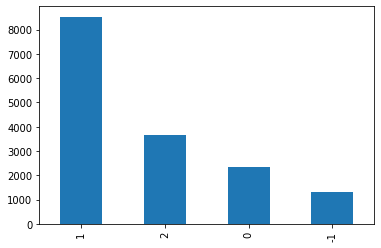

In [5]:
df_train['sentiment'].value_counts().plot(kind = 'bar')
plt.show()

There is a clear disparity in the distribution of the data (2,0,-1 are under represented). Everything needs to be equal before training.

In [30]:
# Indicies of each group
sentiment_0 = df_train[df_train.sentiment == 0]
sentiment_1 = df_train[df_train.sentiment == 1]
sentiment_2 = df_train[df_train.sentiment == 2]
sentiment_n1 = df_train[df_train.sentiment == -1]



In [33]:
# get length of majority sentiment
n_sentiment1 = len(sentiment1)


In [36]:
from sklearn.utils import resample

In [41]:
# Upsample minority class
sentiment_0_upsampled = resample(sentiment_0, replace=True, n_samples=n_sentiment1, random_state=50) 
sentiment_2_upsampled = resample(sentiment_2, replace=True, n_samples=n_sentiment1, random_state=50)
sentiment_n1_upsampled = resample(sentiment_n1, replace=True, n_samples=n_sentiment1, random_state=50)
 

In [42]:
#create new upsampled dataframe
df_upsampled = pd.concat([sentiment_0_upsampled, sentiment_2_upsampled,sentiment_n1_upsampled, sentiment_1])

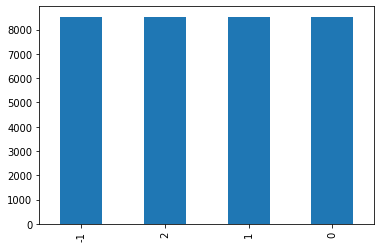

In [43]:
df_upsampled['sentiment'].value_counts().plot(kind = 'bar')
plt.show()

# Preprocessing of data

In [74]:
#make lower case
df_upsampled['message'] = df_upsampled['message'].str.lower()

In [75]:
#remove punctuation
import string

def remove_punctuation_numbers(tweet):
    punc_numbers = string.punctuation + '0123456789'
    return ''.join([l for l in tweet if l not in punc_numbers])

df_upsampled['message'] = df_upsampled['message'].apply(remove_punctuation_numbers)

In [76]:
#remove all stopwords
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(stop_words='english', min_df= .01)
X = vect.fit_transform(df_upsampled['message'])

In [77]:
df = pd.DataFrame(X.A, columns=vect.get_feature_names())
X = pd.DataFrame(X.A, columns=vect.get_feature_names())

In [78]:
col_names = X.columns

In [79]:
col_names

Index(['action', 'al', 'amp', 'believe', 'carbon', 'cause', 'change', 'chief',
       'china', 'chinese', 'climate', 'climatechange', 'cnn', 'data', 'die',
       'does', 'doesnt', 'donald', 'dont', 'earth', 'energy', 'environment',
       'epa', 'fake', 'fight', 'global', 'going', 'good', 'gore', 'great',
       'head', 'hoax', 'https', 'httpst', 'ice', 'im', 'isnt', 'just', 'know',
       'leaders', 'like', 'make', 'man', 'manmade', 'need', 'new', 'news',
       'obama', 'order', 'paris', 'people', 'president', 'pruitt', 'real',
       'realdonaldtrump', 'really', 'right', 'rt', 'said', 'say', 'says',
       'science', 'scientist', 'scientists', 'scott', 'shes', 'stop', 'think',
       'thinking', 'time', 'trump', 'trumps', 'want', 'warming', 'weather',
       'world', 'years'],
      dtype='object')

In [87]:
#add sentiment and to dataframe
y = df_upsampled['sentiment']

#df['y'] = y

y

11385    0
10030    0
12929    0
14408    0
13470    0
        ..
15807    1
15811    1
15812    1
15813    1
15814    1
Name: sentiment, Length: 34120, dtype: int64

# Feature Selection

# Train model

## Split data into train and test data set

In [82]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y)

In [83]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

In [84]:
#create models

lr = LogisticRegression() 
kn = KNeighborsClassifier(5)
svc_linear = SVC(kernel="linear", C=0.05)
svc = SVC(gamma=2, C=1)
dtc = DecisionTreeClassifier(max_depth=10)
rfc = RandomForestClassifier(max_depth=10, n_estimators=10)
abc = AdaBoostClassifier()

In [85]:
#train model on train data
lr.fit(X_train, y_train)
kn.fit(X_train, y_train)
svc_linear.fit(X_train, y_train)
svc.fit(X_train, y_train)
dtc.fit(X_train, y_train)
rfc.fit(X_train, y_train)
abc.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

In [86]:
#predict on test data
lr_pred = lr.predict(X_test)
kn_pred = kn.predict(X_test)
svc_linear_pred = svc_linear.predict(X_test)
svc_pred =  svc.predict(X_test)
dtc_pred = dtc.predict(X_test)
rfc_pred = rfc.predict(X_test) 
abc_pred = abc.predict(X_test)

## Calculate metrics

### Accuracy

In [56]:
from sklearn import metrics

In [88]:
lr_a  = metrics.accuracy_score(y_test, lr_pred)
kn_a  = metrics.accuracy_score(y_test, kn_pred)
svc_linear_a  = metrics.accuracy_score(y_test, svc_linear_pred)
svc_a  = metrics.accuracy_score(y_test, svc_pred)
dtc_a  = metrics.accuracy_score(y_test, dtc_pred)
rfc_a  = metrics.accuracy_score(y_test, rfc_pred)
abc_a  = metrics.accuracy_score(y_test, abc_pred)

In [89]:
print('lr: ', lr_a)
print('kn: ', kn_a)
print('svc_linear: ', svc_linear_a)
print('svc: ', svc_a)
print('dtc: ', dtc_a)
print('rfc :', rfc_a)
print('abc :', abc_a)

lr:  0.48710433763188743
kn:  0.5739742086752637
svc_linear:  0.4792497069167644
svc:  0.6505275498241501
dtc:  0.4388042203985932
rfc : 0.46600234466588514
abc : 0.46576787807737396


### Precision

In [90]:
lr_p  = metrics.precision_score(y_test, lr_pred, average='micro')
kn_p  = metrics.precision_score(y_test, kn_pred, average='micro')
svc_linear_p  = metrics.precision_score(y_test, svc_linear_pred, average='micro')
svc_p  = metrics.precision_score(y_test, svc_pred, average='micro')
dtc_p  = metrics.precision_score(y_test, dtc_pred, average='micro')
rfc_p  = metrics.precision_score(y_test, rfc_pred, average='micro')
abc_p  = metrics.precision_score(y_test, abc_pred, average='micro')

In [91]:
print('lr: ', lr_p)
print('kn: ', kn_p)
print('svc_linear: ', svc_linear_p)
print('svc: ', svc_p)
print('dtc: ', dtc_p)
print('rfc :', rfc_p)
print('abc :', abc_p)

lr:  0.48710433763188743
kn:  0.5739742086752637
svc_linear:  0.4792497069167644
svc:  0.6505275498241501
dtc:  0.4388042203985932
rfc : 0.46600234466588514
abc : 0.46576787807737396


### Recall

In [92]:
lr_r  = metrics.recall_score(y_test, lr_pred, average='micro')
kn_r  = metrics.recall_score(y_test, kn_pred, average='micro')
svc_linear_r  = metrics.recall_score(y_test, svc_linear_pred, average='micro')
svc_r  = metrics.recall_score(y_test, svc_pred, average='micro')
dtc_r  = metrics.recall_score(y_test, dtc_pred, average='micro')
rfc_r  = metrics.recall_score(y_test, rfc_pred, average='micro')
abc_r  = metrics.recall_score(y_test, abc_pred, average='micro')

In [93]:
print('lr: ', lr_r)
print('kn: ', kn_r)
print('svc_linear: ', svc_linear_r)
print('svc: ', svc_r)
print('dtc: ', dtc_r)
print('rfc :', rfc_r)
print('abc :', abc_r)

lr:  0.48710433763188743
kn:  0.5739742086752637
svc_linear:  0.4792497069167644
svc:  0.6505275498241501
dtc:  0.4388042203985932
rfc : 0.46600234466588514
abc : 0.46576787807737396


### F1

In [94]:
lr_f1  = metrics.f1_score(y_test, lr_pred, average='micro')
kn_f1  = metrics.f1_score(y_test, kn_pred, average='micro')
svc_linear_f1  = metrics.f1_score(y_test, svc_linear_pred, average='micro')
svc_f1  = metrics.f1_score(y_test, svc_pred, average='micro')
dtc_f1  = metrics.f1_score(y_test, dtc_pred, average='micro')
rfc_f1  = metrics.f1_score(y_test, rfc_pred, average='micro')
abc_f1  = metrics.f1_score(y_test, abc_pred, average='micro')

In [95]:
print('lr: ', lr_f1)
print('kn: ', kn_f1)
print('svc_linear: ', svc_linear_f1)
print('svc: ', svc_f1)
print('dtc: ', dtc_f1)
print('rfc :', rfc_f1)
print('abc :', abc_f1)

lr:  0.48710433763188743
kn:  0.5739742086752637
svc_linear:  0.4792497069167644
svc:  0.6505275498241501
dtc:  0.4388042203985932
rfc : 0.46600234466588514
abc : 0.46576787807737396


## Tune Hyper parameters

In [65]:
from sklearn.model_selection import GridSearchCV

Since SVC model did the best, we will start with the hyper parameter tuning for it

In [ ]:
nfolds = 2

Cs = [0.001, 0.01, 0.1, 1, 10]
gammas = [0.001, 0.01, 0.1, 1]

param_grid = {
    'C'     : Cs, 
    'gamma' : gammas
    }

grid_SVM = GridSearchCV(SVC(), param_grid, scoring='f1_micro', cv=nfolds)

In [ ]:
grid_SVM.best_params_

Now lets use to new hyperparamers and see if there is an improvement

In [96]:
svc_new = SVC(gamma=1, C=1)

In [97]:
svc_new.fit(X_train, y_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [98]:
svc_new_pred =  svc_new.predict(X_test)

In [99]:
svc_f1_new  = metrics.f1_score(y_test, svc_new_pred, average='micro')
print('svc_new: ', svc_f1_new)

svc_new:  0.6371629542790153


Save model to be used later

In [100]:
import pickle

In [101]:
model_saved_path = 'C:/Users/alta/Documents/Explore/Trains/Sprint 6/kaggle/svc.pkl'

In [102]:
with open(model_saved_path, 'wb') as file: pickle.dump(svc_new, file)